# On-off control
Here we will see how to set up a minimum, working closed loop with a very simple threshold-triggered control scheme.

Preamble:

In [ ]:
import brian2.only as b2
from brian2 import np, ms, Mohm, mA, mV, Hz, nA
import matplotlib.pyplot as plt
import cleo

cleo.utilities.style_plots_for_docs()

# the default cython compilation target isn't worth it for
# this trivial example
b2.prefs.codegen.target = "numpy"

## Set up network
We will use a simple leaky integrate-and-fire network with Poisson spike train input. We use Brian's standard `SpikeMonitor` to view resulting spikes here for simplicity, but see the electrodes tutorial for a more realistic electrode recording scheme.

In [ ]:
n = 10
population = b2.NeuronGroup(
    n,
    """
            dv/dt = (-v - 70*mV + Rm*I) / tau : volt
            tau: second
            Rm: ohm
            I: amp""",
    threshold="v>-50*mV",
    reset="v=-70*mV",
)
population.tau = 10 * ms
population.Rm = 100 * Mohm
population.I = 0 * mA
population.v = -70 * mV

input_group = b2.PoissonGroup(n, np.linspace(0, 100, n) * Hz + 10 * Hz)

S = b2.Synapses(input_group, population, on_pre="v+=5*mV")
S.connect(condition="abs(i-j)<=3")

pop_mon = b2.SpikeMonitor(population)

net = b2.Network([population, input_group, S, pop_mon])

print("Recorded population's equations:")
population.user_equations

Recorded population's equations:


dv/dt = (I*Rm - 70*mV - v)/tau : volt
tau : second
Rm : ohm
I : amp


## Run simulation

In [ ]:
net.run(200 * ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.71s). [brian2.stateupdaters.base.method_choice]


[Text(0.5, 1.0, 'population spiking'),
 Text(0, 0.5, 'neuron index'),
 Text(0.5, 0, 'time (ms)')]

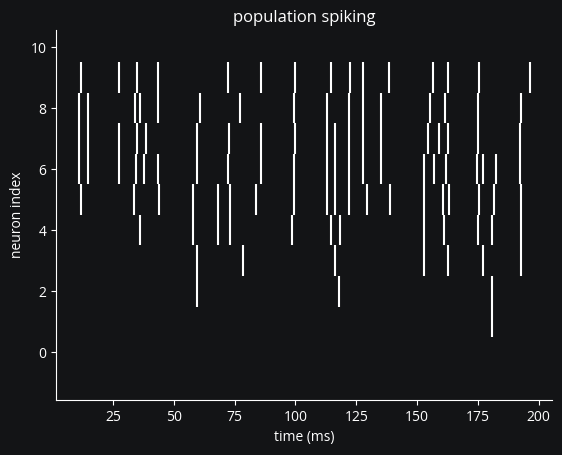

In [ ]:
sptrains = pop_mon.spike_trains()
fig, ax = plt.subplots()
ax.eventplot([t / ms for t in sptrains.values()], lineoffsets=list(sptrains.keys()))
ax.set(title="population spiking", ylabel="neuron index", xlabel="time (ms)")

Because lower neuron indices receive very little input, we see no spikes for neuron 0. Let's change that with closed-loop control.

## IO processor setup
We use the `IOProcessor` class to define interactions with the network.
To achieve our goal of making neuron 0 fire, we'll use a contrived, simplistic setup where
1.  the recorder reports the voltage of a given neuron (of index 5 in our case),
2.  the controller outputs a pulse whenever that voltage is below a certain threshold, and
3.  the stimulator applies that pulse to the specified neuron. 

So if everything is wired correctly, we'll see bursts of activity in just the first neuron.

In [ ]:
i_rec = int(n / 2)
i_ctrl = 0
sim = cleo.CLSimulator(net)
v_rec = cleo.recorders.VoltageRecorder(name="rec")
sim.inject(v_rec, population[i_rec])
sim.inject(
    cleo.stimulators.StateVariableSetter(name="stim", variable_to_ctrl="I", unit=nA),
    population[i_ctrl],
)

CLSimulator(io_processor=None, devices={StateVariableSetter(name='stim', save_history=True, value=0, variable_to_ctrl='I', unit=namp, neuron_groups=[<Subgroup 'neurongroup_subgroup_1' of 'neurongroup' from 0 to 1>]), VoltageRecorder(name='rec', save_history=True, voltage_var_name='v', mon=<StateMonitor, recording ['v'] from 'neurongroup_subgroup'>)})

We need to implement the `LatencyIOProcessor` object. For a more sophisticated case we'd use `ProcessingBlock` objects to decompose 
the computation in the `process` function.

In [ ]:
class ReactivePulseIOProcessor(cleo.ioproc.LatencyIOProcessor):
    def __init__(self, pulse_current=1):
        super().__init__(sample_period=1 * ms)
        self.pulse_current = pulse_current
        self.trigger_threshold = -60 * mV
        self.out = {}

    def process(self, state_dict, time_ms):
        v = state_dict["rec"]
        if v is not None and v < self.trigger_threshold:
            self.out["stim"] = self.pulse_current
        else:
            self.out["stim"] = 0

        return (self.out, time_ms)


sim.set_io_processor(ReactivePulseIOProcessor(pulse_current=1))

CLSimulator(io_processor=ReactivePulseIOProcessor(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={StateVariableSetter(name='stim', save_history=True, value=0, variable_to_ctrl='I', unit=namp, neuron_groups=[<Subgroup 'neurongroup_subgroup_1' of 'neurongroup' from 0 to 1>]), VoltageRecorder(name='rec', save_history=True, voltage_var_name='v', mon=<StateMonitor, recording ['v'] from 'neurongroup_subgroup'>)})

And run the simulation:

In [ ]:
sim.run(200 * ms)

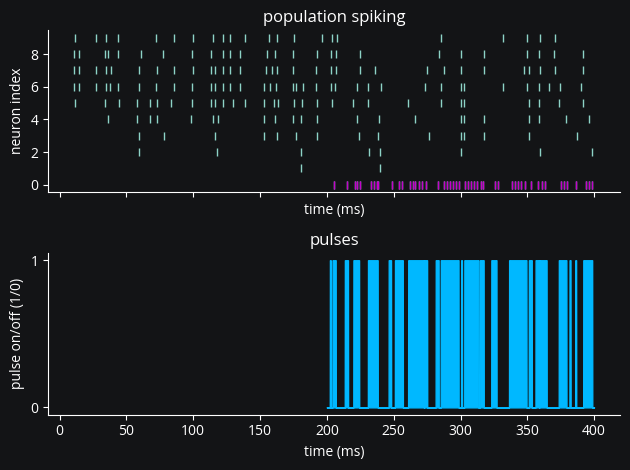

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(pop_mon.t / ms, pop_mon.i, "|")
ax1.plot(
    pop_mon.t[pop_mon.i == i_ctrl] / ms,
    pop_mon.i[pop_mon.i == i_ctrl],
    "|",
    c="#C500CC",
)
ax1.set(title="population spiking", ylabel="neuron index", xlabel="time (ms)")
ax2.fill_between(
    v_rec.mon.t / ms,
    (v_rec.mon.v.T < sim.io_processor.trigger_threshold)[:, 0],
    color=(0.0, 0.72, 1.0),
)
ax2.set(title="pulses", xlabel="time (ms)", ylabel="pulse on/off (1/0)", yticks=[0, 1])
plt.tight_layout()

Yes, we see the IO processor triggering pulses as expected.
And here's a plot of neuron 5's voltage to confirm that those pulses
are indeed where we expect them to be, whenever the voltage is
below -60 mV.

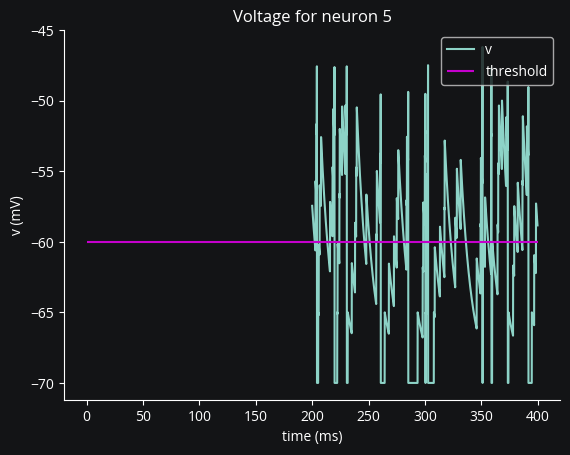

In [ ]:
fig, ax = plt.subplots()
ax.set(title=f"Voltage for neuron {i_rec}", ylabel="v (mV)", xlabel="time (ms)")
ax.plot(v_rec.mon.t / ms, v_rec.mon.v.T / mV)
ax.hlines(-60, 0, 400, color="#c500cc")
ax.legend(["v", "threshold"], loc="upper right");

## Conclusion
In this tutorial we've seen the basics of configuring an `IOProcessor` to implement a closed-loop intervention on a Brian network simulation.